In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
pip install git+https://github.com/facebookresearch/detectron2.git

In [4]:
import detectron2

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [8]:
!curl -L "https://universe.roboflow.com/ds/cVu5wJnRzc?key=hgnnzvmdru" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2068      0 --:--:-- --:--:-- --:--:--  2071
100 13.0M  100 13.0M    0     0  3311k      0  0:00:04  0:00:04 --:--:-- 5600k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/555555_png.rf.f0b784ab8c7603aa75552f71b54a76d9.jpg  
 extracting: test/Screenshot__-_-_-_-_-_-_-_-_-_-_-_-_-_-_png.rf.086c81e9b06df7967a2f8a8744a3c07a.jpg  
 extracting: test/Screenshot__-_-_-_-_-_-_-_-_-_-_-_-_-_-_png.rf.2ba75583b2005daaba803545342fee8d.jpg  
 extracting: test/Screenshot__-_-_-_-_-_-_-_-_-_-_-_-_-_-_png.rf.2ce8b64edb276fd783debcfb0078ce0a.jpg  
 extracting: test/Screenshot__-_-_-_-_-_-_-_-_-_-_-_-_-_-_png.rf.32df635684473523420d2436e1db5978.jpg  
 extracting: test/Screenshot__-_-_-_-_-_-_-_-_-_-_-_-_-_-_png.rf.3867568969cdf3

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



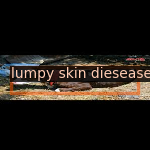

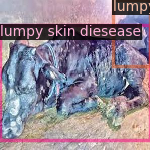

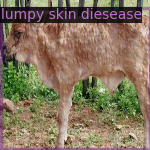

In [10]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # Adjust this value as needed
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

In [13]:
test_metadata = MetadataCatalog.get("my_dataset_test")

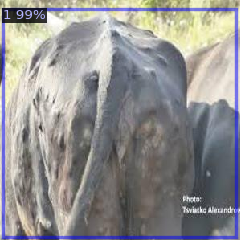

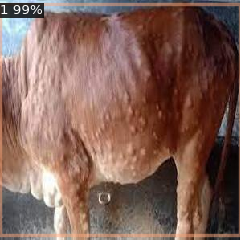

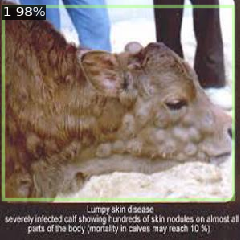

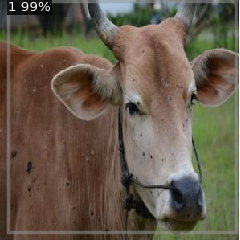

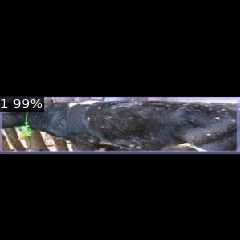

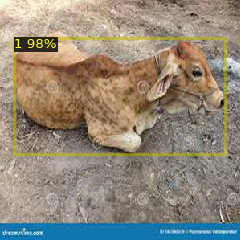

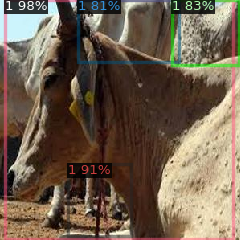

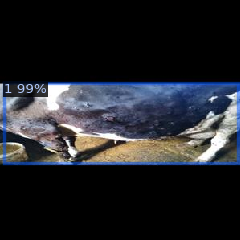

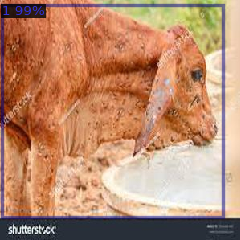

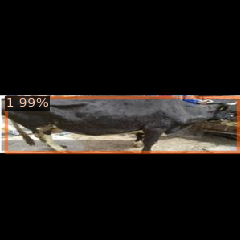

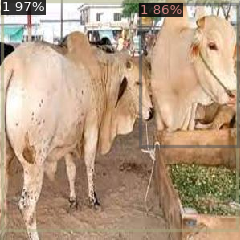

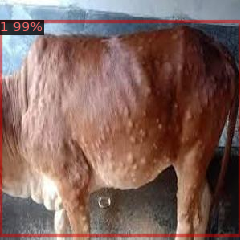

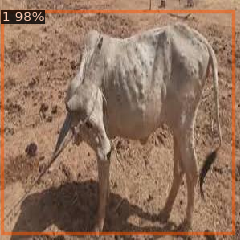

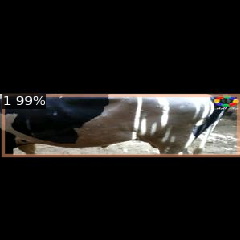

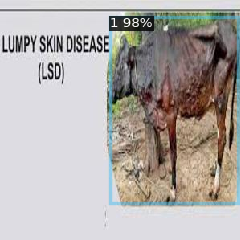

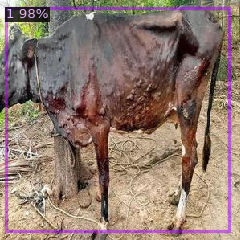

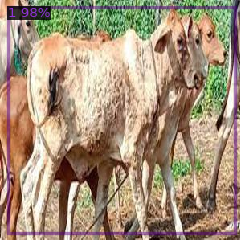

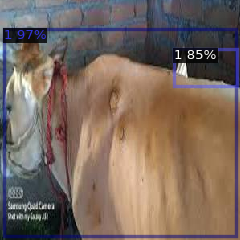

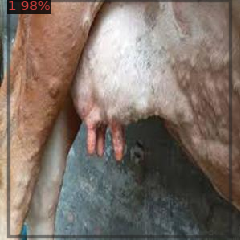

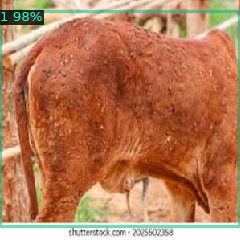

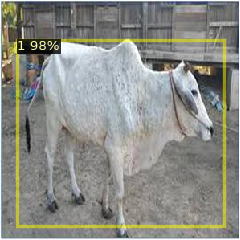

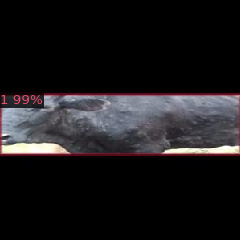

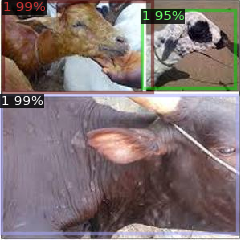

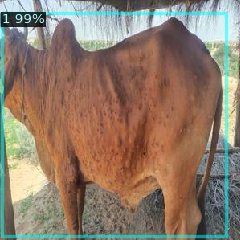

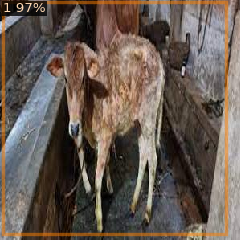

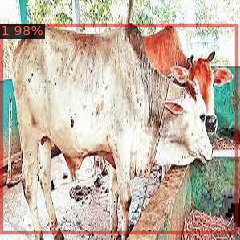

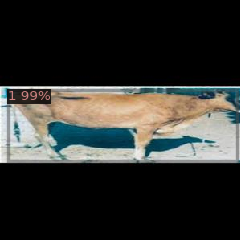

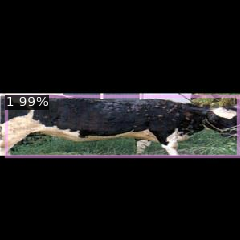

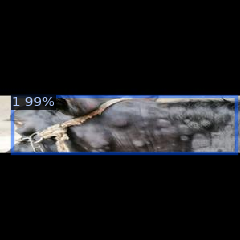

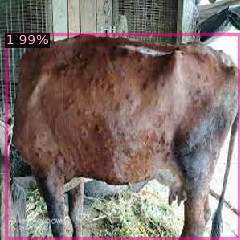

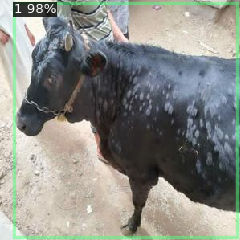

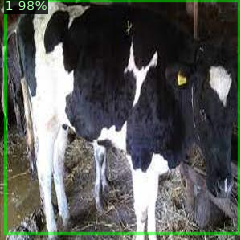

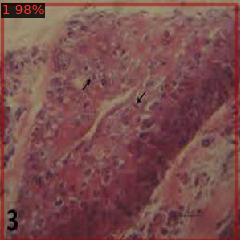

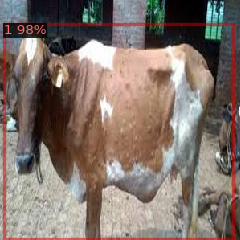

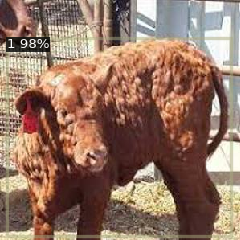

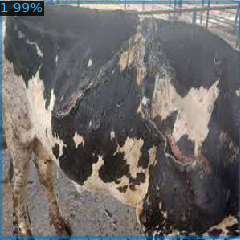

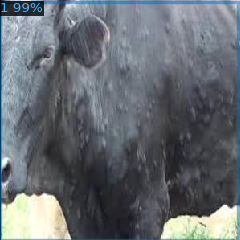

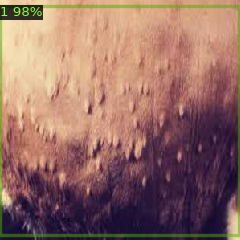

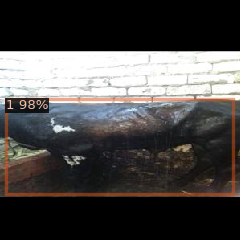

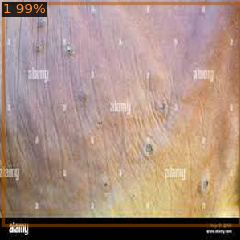

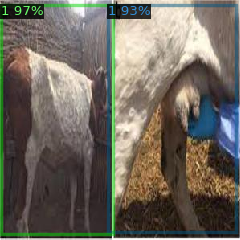

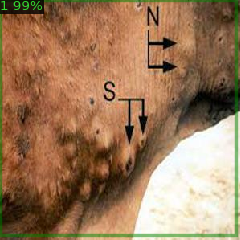

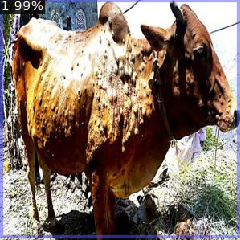

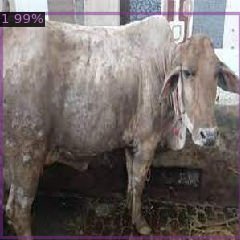

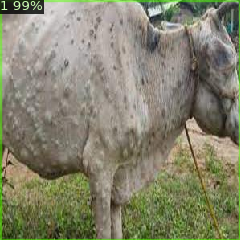

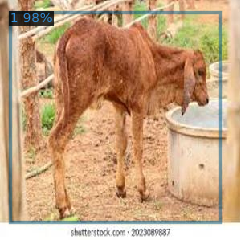

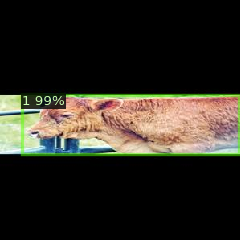

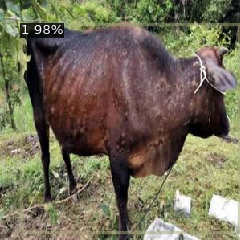

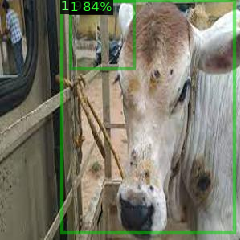

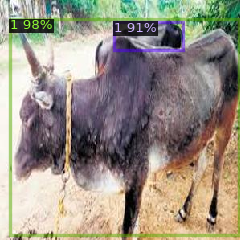

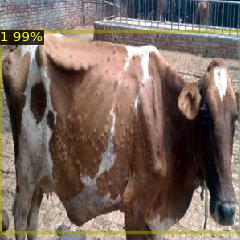

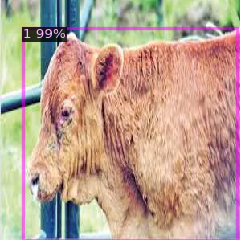

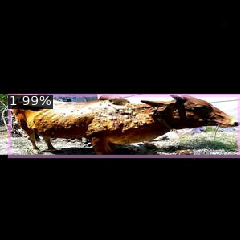

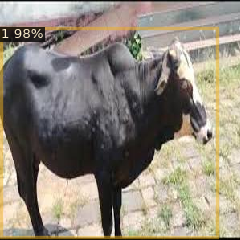

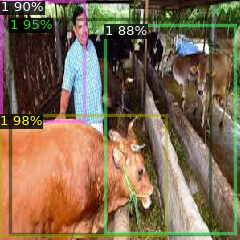

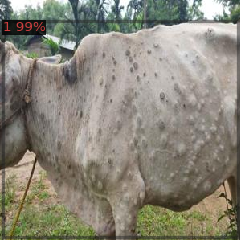

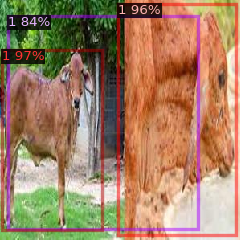

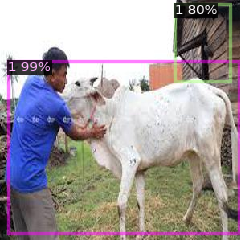

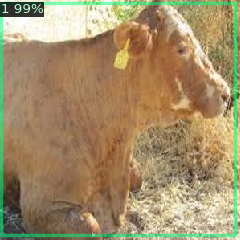

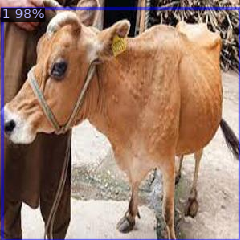

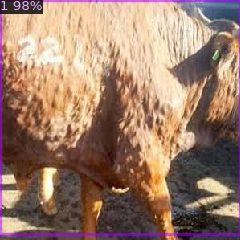

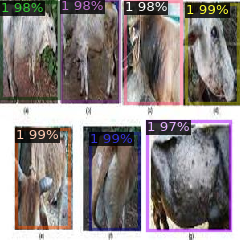

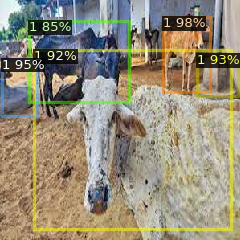

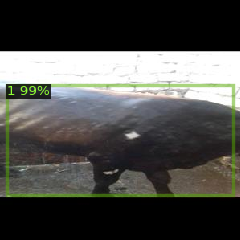

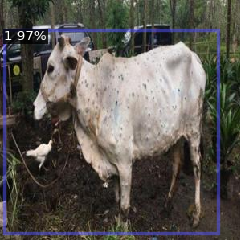

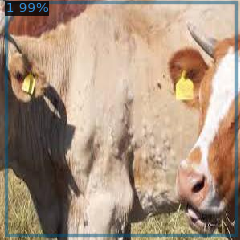

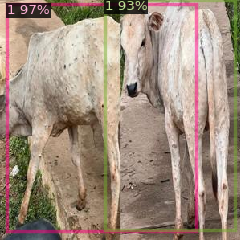

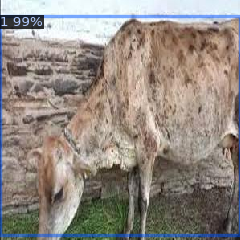

In [14]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [07/30 12:35:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/30 12:35:26 d2.data.datasets.coco]: Loaded 68 images in COCO format from /content/test/_annotations.coco.json
[07/30 12:35:26 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|
| cow-lumpy-s.. | 0            | lumpy skin .. | 94           |
|               |              |               |              |
|     total     | 94           |               |              |
[07/30 12:35:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/30 12:35:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/30 12:35:26 d2.data.common]: Serializing 68 e

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/30 12:35:27 d2.evaluation.evaluator]: Inference done 11/68. Dataloading: 0.0019 s/iter. Inference: 0.0780 s/iter. Eval: 0.0003 s/iter. Total: 0.0802 s/iter. ETA=0:00:04
[07/30 12:35:32 d2.evaluation.evaluator]: Total inference time: 0:00:05.155184 (0.081828 s / iter per device, on 1 devices)
[07/30 12:35:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.078720 s / iter per device, on 1 devices)
[07/30 12:35:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/30 12:35:32 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[07/30 12:35:32 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[07/30 12:35:32 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/30 12:35:32 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[07/30 12:35:32 d2.evaluation.

In [16]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()